 #                                                **Exploring Breathcode data**

### Importing necessary libraries

In [9]:
pip install pandas matplotlib seaborn


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Loading the data

In [11]:
data = pd.read_csv('../sources/heroku-form-entry.csv', dtype={'utm_content': 'object', 'current_download': 'object', 'state': 'object', 'lead_type': 'object', 'lead_generation_app':'object'})

/tmp/ipykernel_3472/3108895423.py:1: DtypeWarning: Columns (28,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../sources/heroku-form-entry.csv', dtype={'utm_content': 'object', 'current_download': 'object', 'state': 'object', 'lead_type': 'object', 'lead_generation_app':'object'})


## Data Cleaning

**Changing column type of date columns**

In [12]:
data.shape

(54237, 47)

In [13]:
data['created_at'].head()

0    2020-11-28 07:46:58.469198+00:00
1    2021-06-22 04:29:19.572742+00:00
2    2020-09-23 21:22:11.861392+00:00
3    2020-09-24 04:36:26.286289+00:00
4    2020-09-25 02:34:58.527898+00:00
Name: created_at, dtype: object

In [14]:
#Changing type of 3 datetime columns 

data[['created_at','updated_at','won_at']] = data[['created_at','updated_at','won_at']].apply(pd.to_datetime).copy()

In [15]:
data['created_at'] = data['created_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
data['updated_at'] = data['updated_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
data['won_at'] = data['won_at'].dt.strftime("%Y-%m-%d %H:%M:%S")

In [16]:
data[['created_at','updated_at','won_at']] = data[['created_at','updated_at','won_at']].apply(pd.to_datetime).copy()

In [17]:
#The column of our interest is 'Created_at' so we'll convert and separate that one first

data['year-month'] = data['created_at'].dt.strftime('%Y-%m')
data['created_time'] = data['created_at'].dt.strftime('%H:%M:%S')

**Create a full name column**

In [18]:
#Combine first and last name ignoring nulls
data['fullname'] = data['first_name'].fillna('') + str(' ') + data['last_name'].fillna('')

In [19]:
# shift column 'Fullname' to first position
fourth_column = data.pop('fullname')

# insert column using insert(position,column_name,fourth_column) function
data.insert(3, 'fullname', fourth_column)

**Dropping columns with 100% of null values and also non relevant columns**

<Figure size 1500x1500 with 0 Axes>

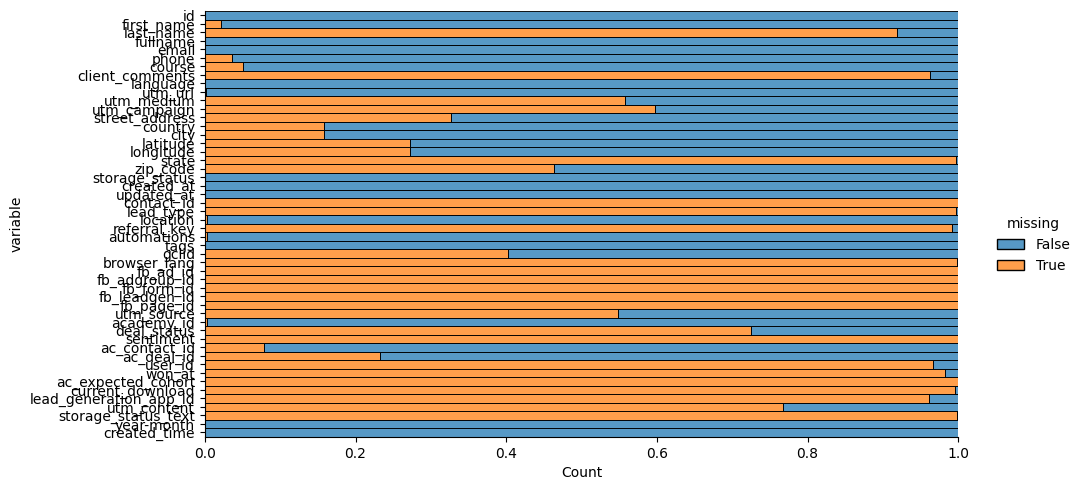

In [20]:
plt.figure(figsize=(15,15))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2
)
plt.show()

In [21]:
#Let's drop columns that have all null values.

data.dropna(axis=1, how='all', inplace=True)

In [22]:
#Let's also drop not relevant columns.

data = data.drop(['client_comments','street_address','city','state',
                  'zip_code','referral_key','browser_lang','ac_expected_cohort','current_download','utm_content',
                  'storage_status','user_id','ac_contact_id','first_name','last_name','storage_status_text'], axis=1).copy()

In [23]:
#Dropping rows that were only for test (identify the rest of test emails pending)
data.drop(data[data['utm_source'] == 'test_s'].index, inplace = True)
data.drop(data[data['utm_source'] == 'fintech'].index, inplace = True)
data.drop(data[data['utm_medium'] == 'xxxxx'].index, inplace = True)
data.drop(data[data['utm_medium'] == 'marico'].index, inplace = True)

In [24]:
#some test rows identified
data = data[data["email"].str.contains("@4geeks") == False]

**Reduce dataframe to only one application (first) per email, and combine with duplicated (if so)**

In [25]:
#How many unique emails are there in the dataset?
data['email'].nunique()

40685

**Testing the removal and combination of duplicates**

In [26]:
# Creating a duplicates dataframe to try different methods to combine data

duplicateRowsDF = data[data.duplicated(['email'],keep= False)]
print("All Duplicate Rows based on email:"," ", duplicateRowsDF.shape)

duplicateRowsDF.groupby(['email','created_at','utm_medium','utm_source']).size()

All Duplicate Rows based on email:   (21960, 27)


email                         created_at           utm_medium  utm_source 
01dilvandromarcelo@gmail.com  2022-10-20 00:24:42  cpc         google         2
02sergioconde@gmail.com       2021-11-02 01:19:40  cpc         google         1
1211eka@gmail.com             2022-10-10 07:58:13  ppc         Facebook       1
123malber.olivares@gmail.com  2022-05-08 02:08:10  ppc         fb             1
                              2022-06-24 02:39:59  ppc         fb             1
                                                                             ..
zuberlye@gmail.com            2022-03-02 20:25:26  ppc         ig             1
zuluaganeider@gmail.com       2022-04-27 19:16:07  cpc         google         1
                              2022-04-27 19:32:06  cpc         google         1
zumanzuesaubrey29@gmail.com   2022-05-17 14:52:29  referral    careerkarma    1
                              2022-05-17 14:54:14  cpc         google         1
Length: 7061, dtype: int64

In [27]:
duplicateRowsDF = duplicateRowsDF.replace("Nan", np.nan)

# Option 1

data1 = duplicateRowsDF.sort_values("created_at")


In [28]:
data1.head(7)

,id,fullname,email,phone,course,language,utm_url,utm_medium,utm_campaign,country,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time
32,99,Patricia Sanchez,2231valemati@gmail.com,NaN,full-stack,es,https://4geeksacademy.co/es/course/desarrollo-...,NaN,NaN,Venezuela,...,request_more_info,NaN,NaN,1.0,NaN,NaN,NaT,NaN,2020-09,11:28:12
46,100,Patricia Sanchez,2231valemati@gmail.com,5.068306e+10,NaN,es,https://4geeksacademy.co/es/aplica,NaN,NaN,Venezuela,...,website-lead,NaN,NaN,8.0,NaN,NaN,NaT,NaN,2020-09,11:54:39
12,106,Annelis Fuenmayor,annelisfuenmayor@gmail.com,9.498802e+08,full-stack,es,https://4geeksacademy.co/us/apply,NaN,NaN,Chile,...,website-lead,NaN,NaN,5.0,NaN,NaN,NaT,NaN,2020-09,13:07:16
49,107,Anne F,annelisfuenmayor@gmail.com,5.694988e+10,software-engineering,es,https://4geeksacademy.co/us/apply,NaN,NaN,Chile,...,website-lead,NaN,NaN,5.0,NaN,NaN,NaT,NaN,2020-09,13:07:38
51,112,Patricia Sanchez,2231valemati@gmail.com,5.068306e+10,full-stack,es,https://4geeksacademy.co/es/aplica,NaN,NaN,Venezuela,...,website-lead,NaN,NaN,8.0,NaN,NaN,NaT,NaN,2020-09,15:30:37
28852,113,Daniel Suarez,ingsuarezcda@gmail.com,NaN,NaN,es,https://4geeksacademy.co/us/location/impact-hub,NaN,NaN,Spain,...,request_more_info,NaN,NaN,6.0,NaN,15186.0,NaT,NaN,2020-09,15:48:03
6,114,Patricia Sanchez,2231valemati@gmail.com,5.068306e+10,full-stack,es,https://4geeksacademy.co/es/aplica,NaN,NaN,NaN,...,website-lead,NaN,NaN,7.0,NaN,NaN,NaT,NaN,2020-09,17:16:51


In [29]:
data1 = data1.groupby("email").first().reset_index()
data1.head()

,email,id,fullname,phone,course,language,utm_url,utm_medium,utm_campaign,country,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time
0,010.sergio@gmail.com,982,Sergio,9.641998e+08,software-engineering,es,https://4geeksacademy.co/es/course/ingenieria-...,None,None,Remoto,...,request_more_info,Cj0KCQiA7qP9BRCLARIsABDaZzjSqM5HLJ_mnXJR0chAmh...,None,7.0,None,NaN,NaT,NaN,2020-11,22:43:38
1,01dilvandromarcelo@gmail.com,53966,Dilvandro Marcelo Fernandes Ramos,3.519396e+11,full-stack,en,https://4geeksacademy.com/us/landing/europe-po...,cpc,16168125570,Portugal,...,request_more_info,CjwKCAjwwL6aBhBlEiwADycBIAFbJP4a6uOs6CDiwSqh8t...,google,10.0,None,70015.0,NaT,NaN,2022-10,00:24:42
2,02sergioconde@gmail.com,15671,Sergio,6.810900e+08,full-stack,en,https://4geeksacademy.com/es/aplica,cpc,12321016929,Spain,...,website-lead,CjwKCAjwoP6LBhBlEiwAvCcthEg_m41UBa1VgX4neAax9f...,google,6.0,LOST,29045.0,NaT,NaN,2021-11,01:19:40
3,07.ebad@gmail.com,40414,Ebad Abid,9.231325e+11,full-stack,en,https://4geeksacademy.com/us/apply,None,None,France,...,website-lead,None,None,4.0,None,57652.0,NaT,NaN,2022-06,16:41:53
4,0wenbartlet@gmail.com,17693,Owen bartlett,2.503015e+09,full-stack,en,https://4geeksacademy.com/us/coding-bootcamps/...,None,None,Mexico,...,request_more_info,None,None,7.0,None,30652.0,NaT,NaN,2021-11,21:16:31


In [30]:
data1[data1['email']== 'afuenmayor@4geeks.co']

,email,id,fullname,phone,course,language,utm_url,utm_medium,utm_campaign,country,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time


**Implementing the removal and combination of duplicates**

In [31]:
data = data.replace("Nan", np.nan).copy()
data = data.sort_values("created_at").copy()
data = data.groupby("email").first().reset_index()

In [32]:
data.shape

(40685, 27)

**Let's identify if a lead has gclid assigning 1 for True, and 0 for False.**

In [33]:
data['has_gclid'] = np.where(data['gclid'].isnull(), '0', '1')

In [34]:
data['has_gclid'].value_counts()

1    26732
0    13953
Name: has_gclid, dtype: int64

**Fixing Courses**

In [35]:
data['course'].value_counts()

full-stack                      33952
software-engineering             2021
machine-learning-engineering     1797
full-stack-ft                    1350
machine-learning                   80
node-js                            55
full_stack                          9
machine-learning-enginnering        2
coding-introduction                 1
Name: course, dtype: int64

In [36]:
data['course'] = data['course'].replace(['full-stack-ft', 'full_stack', 'full-stack,software-engineering',
                                         'coding-introduction','outcomes'], 'full-stack')

In [37]:
data['course'] = data['course'].replace(['machine-learning', 'machine-learning-enginnering'], 
                                        'machine-learning-engineering')

In [38]:
data['course'].value_counts()

full-stack                      35312
software-engineering             2021
machine-learning-engineering     1879
node-js                            55
Name: course, dtype: int64

**4. Location**

Let's correct the 2 different typings in Maracaibo and Cortijos

In [39]:
data['location'] = data['location'].replace(['maracaibo'], 'maracaibo-venezuela')

In [40]:
data['location'] = data['location'].replace(['los-cortijos-caracas'], 'caracas-venezuela')

In [41]:
data['location'] = data['location'].replace(['lisboa-portugal'], 'lisbon-portugal')

In [42]:
data['location'].value_counts()

caracas-venezuela        7288
santiago-chile           6408
madrid-spain             6107
downtown-miami           4024
bogota-colombia          3573
online                   3229
costa-rica               3164
europe                   2238
orlando                  1058
buenosaires-argentina    1027
mexicocity-mexico         854
quito-ecuador             280
panamacity-panama         258
montevideo-uruguay        225
munich-germany            196
sanjose-uruguay           147
barcelona-spain            92
toronto-canada             86
malaga-spain               66
lisbon-portugal            56
valencia-spain             54
berlin-germany             40
lima-peru                  37
rome-italy                 35
lapaz-bolivia              27
hamburg-germany            18
dublin-ireland             13
maracaibo-venezuela        12
milan-italy                 7
Name: location, dtype: int64

**Fixing Language**

Consider 'us' language inside 'en' for english.

In [43]:
data['language'].value_counts()

en    20017
es    15295
us     5373
Name: language, dtype: int64

In [44]:
data['language'] = data['language'].replace('us', 'en')

In [45]:
data['language'].value_counts()

en    25390
es    15295
Name: language, dtype: int64

**Fixing Academy_id**

In [46]:
data['academy_id'] = np.where((data['location'] == 'maracaibo-venezuela'),
                                2.0, data['academy_id'])
data['academy_id'] = np.where((data['location'] == 'toronto-canada'),
                                4.0, data['academy_id'])
data['academy_id'] = np.where((data['location'] == 'costa-rica') |
                                (data['location'] == 'sanjose-uruguay'),
                                7.0, data['academy_id'])

**Fixing utm_source**

In [47]:
data['utm_source'].value_counts()

google                                                 9102
instagram                                              2514
facebook                                               2392
ig                                                     2043
fb                                                     1728
careerkarma                                            1426
landingjobs?utm_medium=machine-learning-engineering     538
coursereport                                            227
Facebook                                                173
Facebook ads                                            131
aprendemas                                              123
landingjobs?utm_medium=full-stack                       115
zoho_recruite                                            81
facebook_instagram                                       55
bing                                                     48
ActiveCampaign                                           46
landingjobs?utm_medium=RRSS             

In [48]:
#Before making any changes, we should make sure where do those long numbers belong to: instagram or facebook?

pd.options.display.max_rows = 200
data.groupby(['utm_source','utm_medium']).size()

utm_source                                           utm_medium                                    
23848557212380143                                    Instagram_Stories                                    1
23848655532190143                                    Facebook_Mobile_Feed                                 1
23849317251630143                                    Instagram_Feed                                       1
23850705303260143                                    Facebook_Mobile_Feed                                 1
23850859670310143                                    Facebook_Mobile_Feed                                 1
4geeks                                               rrss                                                22
ActiveCampaign                                       email                                               46
Business Manager IG                                  lead gen                                             2
CourseReport                        

**First Conditional assignations**

In [49]:
data['utm_medium'] = np.where((data['utm_source'] == 'Facebook ads') |
                                (data['utm_source'] == 'Facebook_Marketplace') |
                                (data['utm_source'] == 'Facebook_Mobile_Feed') |
                                (data['utm_source'] == 'facebook_awareness') |
                                (data['utm_source'] == 'Facebook_Stories') |
                                (data['utm_source'] == 'Facebook_Desktop_Feed') |
                                (data['utm_source'] == 'Business Manager IG') |
                                (data['utm_source'] == 'Instagram_Feed') |
                                (data['utm_source'] == 'Instagram_Stories'),
                                'cpc', data['utm_medium'])

data['utm_source'] = np.where((data['utm_medium'] == 'Instagram_Stories') |
                                (data['utm_medium'] == 'Instagram_Feed'),
                                'instagram', data['utm_source'])

data['utm_source'] = np.where((data['utm_medium'] == 'Facebook_Mobile_Feed') |
                                (data['utm_medium'] == 'Facebook_Instream_Video') |
                                (data['utm_source'] == 'meta'),
                                'facebook', data['utm_source'])

**Fixing utm_source spelling**

In [50]:
#Fixing spelling of sources in utm_source

data['utm_source'] = data['utm_source'].replace('LInkedin', 'linkedin')
data['utm_source'] = data['utm_source'].replace('CourseReport', 'coursereport')
data['utm_source'] = data['utm_source'].replace(['landingjobs?utm_medium=machine-learning-engineering',
                                            'landingjobs?utm_medium=full-stack', 'landingjobs?utm_medium=RRSS'],
                                            'landingjobs')
data['utm_source'] = data['utm_source'].replace('google_ads', 'google')
data['utm_source'] = data['utm_source'].replace(['Business Manager IG', 'Instagram_Feed', 'ig', 'Instagram_Stories'], 'instagram')
data['utm_source'] = data['utm_source'].replace(['Facebook', 'Facebook ads', 'Facebook_Marketplace', 'Facebook_Mobile_Feed',
                                            'facebook_instagram', 'fb', 'an', 'facebook_awareness', 'Facebook_Stories',
                                            'Facebook_Desktop_Feed'], 'facebook')
data['utm_source'] = data['utm_source'].replace('4geeks', 'ticjob')

**8. Fixing utm_medium:** 

Assing 'referral' to all schoolpage values.
    
Assign referral to all landingjob utm_source.
    
Verify with gclid if a medium should be cpc or not.
    
Join cpc with ppc.


In [51]:
#Making assignations to referral and cpc

data['utm_medium'] = data['utm_medium'].replace(['schoolpage', 'coursereportschoolpage', 'schoolpage?utm_source=careerkarma',
                                    'Blog', 'affiliate_email', 'rrss', 'inscripcion', 'event'], 'referral')
data['utm_medium'] = data['utm_medium'].replace(['ppc', 'FB paid', 'Facebook_Mobile_Feed', 'Instagram_Stories', 'Instagram_Feed',
                                    'Facebook_Instream_Video'],'cpc')
data['utm_medium'] = np.where((data['utm_source'] == 'linkedin') & (data['utm_medium'] == 'social'),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'linkedin') & (data['utm_medium'] == 'Inmail'),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'landingjobs'),
                                'referral', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'careerkarma') & (data['utm_medium'].isnull() == True), 
                          'referral', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'facebook') & (data['utm_medium'].isnull() == True),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'zoho_recruite') & (data['utm_medium'] == 'cpc'),
                          'referral', data['utm_medium'])

**Assignations to null sources and medium according to Gclid**

In [52]:
#Convert medium in cpc or referral if gclid is not null

data['utm_medium'] = np.where((data['utm_medium'].isnull()) &
                    (data['gclid'].str.startswith('Cj')), 
                    'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_medium'].isnull()) &
                    (data['gclid'].str.startswith('cl')), 
                    'referral', data['utm_medium'])

#google

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    ((data['gclid'].str.startswith('Cj')) | 
                    (data['gclid'].str.startswith('EA'))),
                    'google', data['utm_source'])


#facebook

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    (data['gclid'].str.startswith('PAA')),
                    'facebook', data['utm_source'])


#careerkarma

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    (data['gclid'].str.startswith('cl')),
                    'careerkarma', data['utm_source'])

**Assign lead_types depending on the tags.**

In [53]:
data['tags'].value_counts()

request_more_info                    24205
website-lead                         15077
newsletter                             659
contact-us                             253
utec-uruguay                           147
request_downloadable                   136
hiring-partner                          88
jobboard-lead                           80
website-lead,blacks-in-technology       20
download_outcome                        18
Name: tags, dtype: int64

In [54]:
data.loc[data['tags'] == 'request_more_info', 'lead_type'] = 'SOFT'
data.loc[data['tags'] == 'website-lead', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'newsletter', 'lead_type'] = 'DISCOVERY'
data.loc[data['tags'] == 'contact-us', 'lead_type'] = 'SOFT'
data.loc[data['tags'] == 'utec-uruguay', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'jobboard-lead', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'hiring-partner', 'lead_type'] = 'OTHER'
data.loc[data['tags'] == 'download_outcome', 'lead_type'] = 'DISCOVERY'
data.loc[data['tags'] == 'website-lead,blacks-in-technology', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'request_downloadable', 'lead_type'] = 'DISCOVERY'

In [55]:
data['lead_type'].value_counts()

SOFT         24458
STRONG       15324
DISCOVERY      813
OTHER           88
Name: lead_type, dtype: int64

**Change name of null medium and null source**

In [56]:
# change name of null medium

data['utm_medium'] = np.where((data['utm_source'].isnull() == True) & (data['utm_medium'].isnull() == True),
                                'undefined & organic', data['utm_medium'])

# change name of null source

data['utm_source'] = np.where((data['utm_medium'] == 'undefined & organic'),
                                'undefined', data['utm_source'])

**Create a column that registers the filled % of each row**

In [57]:
filled_data = []

for i in range(len(data.index)):
    filled_data.append(((1-((data.iloc[i].isnull().sum())/len(data.columns)))*100))

In [58]:
#assign list to a new column in dataframe

data['% of row filled'] = filled_data

# make new column have only one decimal

data['% of row filled'].round(1)


# Add % symbol to end of column string
# 
# data['filled_data'] = data['filled_data'].astype(str) + '%'

0        82.1
1        85.7
2        85.7
3        89.3
4        82.1
         ... 
40680    78.6
40681    82.1
40682    82.1
40683    82.1
40684    92.9
Name: % of row filled, Length: 40685, dtype: float64

# Creating correct_country Field with phone codes

In [59]:
country_data = {"AF":"Afghanistan",
"AX":"Aland Islands",
"AL":"Albania",
"DZ":"Algeria",
"AS":"American Samoa",
"AD":"Andorra",
"AO":"Angola",
"AI":"Anguilla",
"AQ":"Antarctica",
"AG":"Antigua and Barbuda",
"AR":"Argentina",
"AM":"Armenia",
"AW":"Aruba",
"AU":"Australia",
"AT":"Austria",
"AZ":"Azerbaijan",
"BS":"Bahamas",
"BH":"Bahrain",
"BD":"Bangladesh",
"BB":"Barbados",
"BY":"Belarus",
"BE":"Belgium",
"BZ":"Belize",
"BJ":"Benin",
"BM":"Bermuda",
"BT":"Bhutan",
"BO":"Bolivia",
"BQ":"Bonaire, Sint Eustatius and Saba",
"BA":"Bosnia and Herzegovina",
"BW":"Botswana",
"BV":"Bouvet Island",
"BR":"Brazil",
"IO":"British Indian Ocean Territory",
"BN":"Brunei Darussalam",
"BG":"Bulgaria",
"BF":"Burkina Faso",
"BI":"Burundi",
"KH":"Cambodia",
"CM":"Cameroon",
"CA":"Canada",
"CV":"Cape Verde",
"KY":"Cayman Islands",
"CF":"Central African Republic",
"TD":"Chad",
"CL":"Chile",
"CN":"China",
"CX":"Christmas Island",
"CC":"Cocos (Keeling) Islands",
"CO":"Colombia",
"KM":"Comoros",
"CG":"Congo",
"CD":"Congo",
"CK":"Cook Islands",
"CR":"Costa Rica",
"CI":"Côte d'Ivoire",
"HR":"Croatia",
"CU":"Cuba",
"CW":"Curaçao",
"CY":"Cyprus",
"CZ":"Czech Republic",
"DK":"Denmark",
"DJ":"Djibouti",
"DM":"Dominica",
"DO":"Dominican Republic",
"EC":"Ecuador",
"EG":"Egypt",
"SV":"El Salvador",
"GQ":"Equatorial Guinea",
"ER":"Eritrea",
"EE":"Estonia",
"ET":"Ethiopia",
"FK":"Falkland Islands (Malvinas)",
"FO":"Faroe Islands",
"FJ":"Fiji",
"FI":"Finland",
"FR":"France",
"GF":"French Guiana",
"PF":"French Polynesia",
"TF":"French Southern Territories",
"GA":"Gabon",
"GM":"Gambia",
"GE":"Georgia",
"DE":"Germany",
"GH":"Ghana",
"GI":"Gibraltar",
"GR":"Greece",
"GL":"Greenland",
"GD":"Grenada",
"GP":"Guadeloupe",
"GU":"Guam",
"GT":"Guatemala",
"GG":"Guernsey",
"GN":"Guinea",
"GW":"Guinea-Bissau",
"GY":"Guyana",
"HT":"Haiti",
"HM":"Heard Island and McDonald Islands",
"VA":"Holy See",
"HN":"Honduras",
"HK":"Hong Kong",
"HU":"Hungary",
"IS":"Iceland",
"IN":"India",
"ID":"Indonesia",
"IR":"Iran, Islamic Republic of",
"IQ":"Iraq",
"IE":"Ireland",
"IM":"Isle of Man",
"IL":"Israel",
"IT":"Italy",
"JM":"Jamaica",
"JP":"Japan",
"JE":"Jersey",
"JO":"Jordan",
"KZ":"Kazakhstan",
"KE":"Kenya",
"KI":"Kiribati",
"KP":"Korea, Democratic People's Republic of",
"KR":"Korea, Republic of",
"KW":"Kuwait",
"KG":"Kyrgyzstan",
"LA":"Lao People's Democratic Republic",
"LV":"Latvia",
"LB":"Lebanon",
"LS":"Lesotho",
"LR":"Liberia",
"LY":"Libya",
"LI":"Liechtenstein",
"LT":"Lithuania",
"LU":"Luxembourg",
"MO":"Macao",
"MK":"Macedonia",
"MG":"Madagascar",
"MW":"Malawi",
"MY":"Malaysia",
"MV":"Maldives",
"ML":"Mali",
"MT":"Malta",
"MH":"Marshall Islands",
"MQ":"Martinique",
"MR":"Mauritania",
"MU":"Mauritius",
"YT":"Mayotte",
"MX":"Mexico",
"FM":"Micronesia",
"MD":"Moldova",
"MC":"Monaco",
"MN":"Mongolia",
"ME":"Montenegro",
"MS":"Montserrat",
"MA":"Morocco",
"MZ":"Mozambique",
"MM":"Myanmar",
"NA":"Namibia",
"NR":"Nauru",
"NP":"Nepal",
"NL":"Netherlands",
"NC":"New Caledonia",
"NZ":"New Zealand",
"NI":"Nicaragua",
"NE":"Niger",
"NG":"Nigeria",
"NU":"Niue",
"NF":"Norfolk Island",
"MP":"Northern Mariana Islands",
"NO":"Norway",
"OM":"Oman",
"PK":"Pakistan",
"PW":"Palau",
"PS":"Palestinian Territory, Occupied",
"PA":"Panama",
"PG":"Papua New Guinea",
"PY":"Paraguay",
"PE":"Peru",
"PH":"Philippines",
"PN":"Pitcairn",
"PL":"Poland",
"PT":"Portugal",
"PR":"Puerto Rico",
"QA":"Qatar",
"RE":"Réunion",
"RO":"Romania",
"RU":"Russia",
"RW":"Rwanda",
"BL":"Saint Barthélemy",
"SH":"Saint Helena, Ascension and Tristan da Cunha",
"KN":"Saint Kitts and Nevis",
"LC":"Saint Lucia",
"MF":"Saint Martin (French part)",
"PM":"Saint Pierre and Miquelon",
"VC":"Saint Vincent and the Grenadines",
"WS":"Samoa",
"SM":"San Marino",
"ST":"Sao Tome and Principe",
"SA":"Saudi Arabia",
"SN":"Senegal",
"RS":"Serbia",
"SC":"Seychelles",
"SL":"Sierra Leone",
"SG":"Singapore",
"SX":"Sint Maarten (Dutch part)",
"SK":"Slovakia",
"SI":"Slovenia",
"SB":"Solomon Islands",
"SO":"Somalia",
"ZA":"South Africa",
"GS":"South Georgia and the South Sandwich Islands",
"ES":"Spain",
"LK":"Sri Lanka",
"SD":"Sudan",
"SR":"Suriname",
"SS":"South Sudan",
"SJ":"Svalbard and Jan Mayen",
"SZ":"Swaziland",
"SE":"Sweden",
"CH":"Switzerland",
"SY":"Syrian Arab Republic",
"TW":"Taiwan",
"TJ":"Tajikistan",
"TZ":"Tanzania",
"TH":"Thailand",
"TL":"Timor-Leste",
"TG":"Togo",
"TK":"Tokelau",
"TO":"Tonga",
"TT":"Trinidad and Tobago",
"TN":"Tunisia",
"TR":"Turkey",
"TM":"Turkmenistan",
"TC":"Turks and Caicos Islands",
"TV":"Tuvalu",
"UG":"Uganda",
"UA":"Ukraine",
"AE":"United Arab Emirates",
"GB":"United Kingdom",
"US":"United States",
"UM":"United States Minor Outlying Islands",
"UY":"Uruguay",
"UZ":"Uzbekistan",
"VU":"Vanuatu",
"VE":"Venezuela",
"VN":"Viet Nam",
"VG":"Virgin Islands, British",
"VI":"Virgin Islands, U.S.",
"WF":"Wallis and Futuna",
"YE":"Yemen",
"ZM":"Zambia",
"ZW":"Zimbabwe"}


In [60]:
data['phone'] = data['phone'].apply(lambda x: f'{x:.0f}')
data['phone'] = data['phone'].fillna(0)

In [61]:
data['phone'].isnull().value_counts()

False    40685
Name: phone, dtype: int64

In [62]:
pip install phone_iso3166

  Using cached phone_iso3166-0.4.1-py3-none-any.whl (45 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
from phone_iso3166.country import phone_country

correct_country = []

for row in data.itertuples(index=False):
    if str(row.phone) == '0':
        correct_country.append('No country assigned')
    elif str(row.phone) == 'nan':
        correct_country.append('No country assigned')
    else:
        try:
            code = phone_country(row.phone)    
            correct_country.append(country_data[code])
        except:
            correct_country.append('Error from invalid phone')
                  
        

In [64]:
data['phone_country'] = correct_country

In [65]:
data[['country','phone_country']]

,country,phone_country
0,Remote,Andorra
1,Venezuela,Venezuela
2,United States,Russia
3,Venezuela,Greece
4,Remoto,Iraq
...,...,...
40680,None,United States
40681,Ecuador,Ecuador
40682,Venezuela,Colombia
40683,France,Nigeria


## Creating new column to determine location integrity

In [66]:
LATAM_COUNTRIES = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Paraguay','Peru','Uruguay','Venezuela','Belize',
                    'Costa Rica','Cuba','Dominican Republic','El Salvador','Guatemala','Haiti','Honduras','Jamaica','Mexico','Nicaragua',
                    'Panama','Saint Lucia','Antigua and Barbuda','Guyana','Suriname','Saint Kitts & Nevis','Bahamas','Barbados',
                    'Trinidad and Tobago','Grenada','Saint Vincent and the Grenadines','Dominica']

LATAM_LOCATIONS = ['caracas-venezuela','santiago-chile','bogota-colombia','online','costa-rica','buenosaires-argentina','mexicocity-mexico',
                    'quito-ecuador','panamacity-panama','montevideo-uruguay','sanjose-uruguay','lapaz-bolivia','lima-peru',
                    'maracaibo-venezuela']

EUROPE_COUNTRIES = ['Hungary','Belarus','Austria','Serbia','Switzerland','Germany','Holy See','Andorra','Bulgaria','United Kingdom',
                    'France','Montenegro','Luxembourg','Italy','Denmark','Finland','Slovakia','Norway','Ireland','Spain','Malta',
                    'Ukraine','Croatia','Moldova','Monaco','Liechtenstein','Poland','Iceland','San Marino','Bosnia and Herzegovina',
                    'Albania','Lithuania','Macedonia','Slovenia','Romania','Latvia','Netherlands','Russia','Estonia','Belgium',
                    'Czech Republic','Greece','Portugal','Sweeden']

EUROPE_LOCATIONS = ['madrid-spain','europe','barcelona-spain','malaga-spain','munich-germany','berlin-germany','valencia-spain',
                    'rome-italy','lisbon-portugal','maracaibo-venezuela','hamburg-germany','dublin-ireland','milan-italy','europe']

In [67]:
data['country'] = data['country'].str.lower()
data['phone_country'] = data['phone_country'].str.lower()
LATAM_COUNTRIES = list(map(str.lower,LATAM_COUNTRIES))
EUROPE_COUNTRIES = list(map(str.lower,EUROPE_COUNTRIES))

In [68]:
pip install python-slugify

  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
from slugify import slugify

data['country'] = data['country'].astype(str).apply(lambda x :slugify(x))
data['phone_country'] = data['phone_country'].astype(str).apply(lambda x :slugify(x))

In [70]:
correct_location = []

for row in data.itertuples(index=False):
    def compare_with(target_phone):
        if str(target_phone) in str(row.location):    
            return row.location
        elif str(target_phone) in str('united-states'):    
            return 'downtown-miami'
        elif str(target_phone) in LATAM_COUNTRIES and (v for v in LATAM_LOCATIONS if str(target_phone) in v):  
            latam_search = str(target_phone)
            latam_match = list(filter(lambda x: latam_search in x, LATAM_LOCATIONS))
            return latam_match
        elif str(target_phone) in EUROPE_COUNTRIES and str(target_phone) in EUROPE_LOCATIONS:
            europe_search = str(target_phone)
            europe_match = list(filter(lambda x: europe_search in x, EUROPE_LOCATIONS))
            return europe_match
        elif str(target_phone) in LATAM_COUNTRIES: 
            return 'online'
        elif str(target_phone) in EUROPE_COUNTRIES:  
            return 'europe'
        return None

    location = compare_with(row.phone_country) if str(row.phone_country) not in ['Error from invalid phone','No country assigned'] else None
    if  location is not None:
        correct_location.append(location)
        continue

    if location:= compare_with(row.country):
        correct_location.append(location)
        continue
        
    correct_location.append('No location assigned')

#create new column with the values of correct_location list

data['correct_location'] = correct_location

#remove '[ ]' from any list in correct_location column (created because of having more than one item)

f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
data['correct_location'] = data['correct_location'].apply(f)


In [71]:
'''
2nd option to create correct_location column (works but not optimal code)
correct_location = []

for row in data.itertuples(index=False):
    if str(row.phone_country) in str(row.location):    
        correct_location.append(row.location)
    elif str(row.phone_country) in str('united-states'):    
        correct_location.append('downtown-miami')
    elif str(row.phone_country) in LATAM_COUNTRIES and (v for v in LATAM_LOCATIONS if str(row.phone_country) in v):  
        latam_search = str(row.phone_country)
        latam_match = list(filter(lambda x: latam_search in x, LATAM_LOCATIONS))
        correct_location.append(latam_match)
    elif str(row.phone_country) in EUROPE_COUNTRIES and str(row.phone_country) in EUROPE_LOCATIONS:
        europe_search = str(row.phone_country)
        europe_match = list(filter(lambda x: europe_search in x, EUROPE_LOCATIONS))
        correct_location.append(europe_match)
    elif str(row.phone_country) in LATAM_COUNTRIES: 
        correct_location.append('online')
    elif str(row.phone_country) in EUROPE_COUNTRIES:  
        correct_location.append('europe')

    elif str(row.phone_country) not in ['Error from invalid phone','No country assigned']:
        correct_location.append('No location assigned')   

    elif str(row.country) in str(row.location):    
        correct_location.append(row.location)
    elif str(row.country) in str('united-states'):    
        correct_location.append('downtown-miami')
    elif str(row.country) in LATAM_COUNTRIES and (v for v in LATAM_LOCATIONS if str(row.country) in v):  
        latam_search = str(row.country)
        latam_match = list(filter(lambda x: latam_search in x, LATAM_LOCATIONS))
        correct_location.append(latam_match)
    elif str(row.country) in EUROPE_COUNTRIES and str(row.country) in EUROPE_LOCATIONS:
        europe_search = str(row.country)
        europe_match = list(filter(lambda x: europe_search in x, EUROPE_LOCATIONS))
        correct_location.append(europe_match)
    elif str(row.country) in LATAM_COUNTRIES: 
        correct_location.append('online')
    elif str(row.country) in EUROPE_COUNTRIES:  
        correct_location.append('europe')
        
    else:
        correct_location.append('No location assigned')
'''   

"\n2nd option to create correct_location column (works but not optimal code)\ncorrect_location = []\n\nfor row in data.itertuples(index=False):\n    if str(row.phone_country) in str(row.location):    \n        correct_location.append(row.location)\n    elif str(row.phone_country) in str('united-states'):    \n        correct_location.append('downtown-miami')\n    elif str(row.phone_country) in LATAM_COUNTRIES and (v for v in LATAM_LOCATIONS if str(row.phone_country) in v):  \n        latam_search = str(row.phone_country)\n        latam_match = list(filter(lambda x: latam_search in x, LATAM_LOCATIONS))\n        correct_location.append(latam_match)\n    elif str(row.phone_country) in EUROPE_COUNTRIES and str(row.phone_country) in EUROPE_LOCATIONS:\n        europe_search = str(row.phone_country)\n        europe_match = list(filter(lambda x: europe_search in x, EUROPE_LOCATIONS))\n        correct_location.append(europe_match)\n    elif str(row.phone_country) in LATAM_COUNTRIES: \n        c

In [72]:
data['correct_location'] = correct_location

In [73]:
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
data['correct_location'] = data['correct_location'].apply(f)

In [74]:
data[['phone','country','phone_country','location','correct_location']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40685 entries, 0 to 40684
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone             40685 non-null  object
 1   country           40685 non-null  object
 2   phone_country     40685 non-null  object
 3   location          40619 non-null  object
 4   correct_location  40685 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [75]:
data[['phone','country','phone_country','location','correct_location']]

,phone,country,phone_country,location,correct_location
0,376651893,remote,andorra,europe,europe
1,5804129362947,venezuela,venezuela,caracas-venezuela,caracas-venezuela
2,7869161892,united-states,russia,downtown-miami,europe
3,3014055601,venezuela,greece,bogota-colombia,europe
4,964199806,remoto,iraq,online,No location assigned
...,...,...,...,...,...
40680,18324951725,none,united-states,downtown-miami,downtown-miami
40681,593984690966,ecuador,ecuador,quito-ecuador,quito-ecuador
40682,573160728002,venezuela,colombia,costa-rica,bogota-colombia
40683,2348169146697,france,nigeria,europe,europe
